In [1]:
import sys
sys.path.append('../bayesopt')

import read_agg_data
import torch
import torch.nn as nn
import torch.autograd as auto
import torch.optim as optim

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import math

import pdb

dvfs_dict = {
    "0xc00" :  1.2,
    "0xd00" :  1.3,
    "0xe00" :  1.4,
    "0xf00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
    "0xffff" : 3.0,
}

In [2]:
#df_comb, _, _ = read_agg_data.start_analysis('mcd') #DATA
#df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: int(x, base=16))

df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/mcd_combined.csv', sep=' ')
print(df_comb.shape[0])
df_comb['QPS'] = df_comb['target_QPS']

print(df_comb['QPS'].unique())
df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
#df_comb = df_comb[(df_comb['rapl'] == 135)]
df_comb = df_comb[df_comb['read_99th'] <= 500]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic
print(df_comb.columns)

# df_comb['dvfs'] = df_comb['dvfs'].astype(float) / df_comb['dvfs'].min()
# print(df_comb['dvfs'].unique())
# df_comb['itr'] = df_comb['itr'].astype(float) / df_comb['itr'].min()
# print(df_comb['itr'].unique())
#print(10**6)
print(df_comb['QPS'].unique())

3073
[200000 400000 600000      0]
Index(['sys', 'i', 'itr', 'dvfs', 'rapl', 'read_5th', 'read_10th', 'read_50th',
       'read_90th', 'read_95th', 'read_99th', 'measure_QPS', 'target_QPS',
       'time', 'joules', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes',
       'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c1', 'c1e', 'c3',
       'c6', 'c7', 'num_interrupts', 'QPS'],
      dtype='object')
[400000 600000 200000]


[ 50 100 200 300 400 350]
1675.5
******* ebbrt_tuned 50 200000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
174              0.000209   50   1.7         5221529  1.899239e+11      103.8
262              0.000223   50   1.9         5221089  1.844129e+11      103.4
351              0.000240   50   2.1         5220371  1.796836e+11      103.3
440              0.000258   50   2.3         5214101  1.763346e+11      103.9
526              0.000277   50   2.5         5220459  1.737004e+11      103.8
616              0.000296   50   2.7         5223052  1.701433e+11      103.0
706              0.000321   50   2.9         5216163  1.690650e+11      102.8

1836.46
******* ebbrt_tuned 50 400000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
4                0.000168   50   1.3         6036916  3.025599e+11      104.1
92               0.000180   50   1.5         6035703  2.803556e+11      104.9
179              0.000194   50   1.7    

     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
39               0.000635  200   1.3         1562466  2.697584e+11      249.7
126              0.000673  200   1.5         1562481  2.621141e+11      262.6
214              0.000726  200   1.7         1562444  2.439520e+11      248.8
304              0.000757  200   1.9         1562470  2.284070e+11      250.3
392              0.000801  200   2.1         1562464  2.331850e+11      257.3
479              0.000853  200   2.3         1562467  2.306333e+11      262.2
568              0.000916  200   2.5         1562460  2.317443e+11      255.8
658              0.001002  200   2.7         1562459  2.183752e+11      249.9
748              0.001074  200   2.9         1562468  2.143033e+11      248.7

1962.71
******* ebbrt_tuned 200 600000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
45               0.000664  200   1.3         1562473  3.654273e+11      274.8
132              0.00070

1836.46
******* ebbrt_tuned 350 400000
Empty DataFrame
Columns: [joules_per_interrupt, itr, dvfs, num_interrupts, ref_cycles, read_99th]
Index: []

1962.71
******* ebbrt_tuned 350 600000
Empty DataFrame
Columns: [joules_per_interrupt, itr, dvfs, num_interrupts, ref_cycles, read_99th]
Index: []

2106.63
******* linux_tuned 350 200000
      joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
1978              0.001184  350   1.3          892879  3.570502e+11      449.6
2051              0.001275  350   1.5          892890  3.224655e+11      443.8
2123              0.001368  350   1.7          892913  2.880056e+11      441.6
2195              0.001468  350   1.9          892689  2.704350e+11      439.8
2267              0.001585  350   2.1          892793  2.461656e+11      437.7
2371              0.001702  350   2.3          892838  2.379652e+11      437.0
2459              0.001831  350   2.5          892558  2.210142e+11      436.8
2547              0.001982  350  

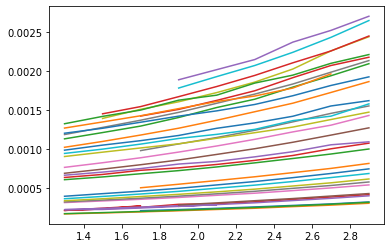

In [3]:
print(df_comb['itr'].unique())
for itr in [50, 100, 200, 300, 350, 400]:
    for sys in ['ebbrt_tuned', 'linux_tuned']:
        for qps in [200000, 400000, 600000]:
            df = df_comb[(df_comb['sys']==sys) & (df_comb['QPS'] == qps)].copy()
            #print(df.shape[0])
            print(df['joules'].max())
            df['joules_per_interrupt'] = df['joules']/df['num_interrupts']
            df = df[['joules_per_interrupt','itr', 'dvfs', 'num_interrupts', 'ref_cycles', 'read_99th']]
            #print(df.shape[0])
            #print('')
            
            dfi = df[df['itr']==itr]
            #dfi = dfi.drop_duplicates(subset = ["itr", "dvfs"])
            #dfi['joules_mean'] = dfi['joules_mean']/dfi['joules_mean'].max()
            #print(dfi.diff())
            print('*******', sys, itr, qps)
            print(dfi.sort_values(by=['dvfs']))
            #print(dfi.sort_values(by=['dvfs']).diff())
            print('')
            plt.plot(dfi['dvfs'], dfi['joules_per_interrupt'])
            #print(dfi)

In [21]:
def inference_time(d, n_iter, lr, workload, sys, fzeta, falpha, fphi, print_freq=1000):
    # p_busy_min = 20
    p_static = {
        'c1':1.5, 
        'c3':0.5,
        'c4':0.25,
        'c7':34, # 34 Watts
        'busy': 10
    }
    chosen_sleep = 'c7'

    p_q = p_static[chosen_sleep]/10**6 # joules/us idle
    # p_detect = p_static[chosen_sleep]

    #starts
    zeta = torch.tensor(torch.Tensor(1,1).uniform_(fzeta[0], fzeta[1]), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(falpha[0], falpha[1]), requires_grad=True)
    phi = torch.tensor(torch.Tensor(1,1).uniform_(fphi[0], fphi[1]), requires_grad=True)
    
    #p_static_busy = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_detect = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_q = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_busy_min = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)    
    #AA = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #BB = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    #df[['joules','itr', 'dvfs', 'QPS', read_99th, 'num_interrupts']]
    qps = d[:,3]
    ninterrupts = d[:,5]
    energy = (d[:,0]/ninterrupts).log() ## joules/num_interrupts
    #energy = (d[:,0]/(qps).log()
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,4]
     
    #interarrival_time = (1/qps)*10**6
    criterion = nn.MSELoss()
    optimizer_time = optim.Adam([zeta, alpha, phi], lr=lr)

    for i in range(n_iter):        
        t_busy = (zeta / dvfs**(1+alpha)) ## as dvfs increases, max_time should get smaller
        pred_time = (phi*itr) + t_busy ## itr_suppress reflects where pkt is in queue
        
        loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        if i % print_freq == 0:
            print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item()), 5)} us'
            +f' zeta={zeta.item()} alpha={alpha.item()} phi={phi.item()}')
            
        optimizer_time.zero_grad()
        loss_time.backward(retain_graph=True)
        optimizer_time.step()
    
    return pred_time

In [22]:
def run_time(df_comb, n_iter=2000, lr=1, rqps=400000, rtail='99', 
             msys=['ebbrt_tuned'], mpred=['energy', 'time'], 
             fzeta=[0, 500], falpha=[-2.0, 2.0], fphi=[-2.0, 2.0]):
    df_comb = df_comb[df_comb['QPS'] == rqps]

    i=1
    
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        rt = 'read_'+rtail+'th'
        df = df[['joules','itr', 'dvfs', 'QPS', rt, 'num_interrupts']]
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        pred_time = inference_time(d, n_iter, lr, 'mcd', sys, fzeta, falpha, fphi)
        
        df[f'pre_time lr={lr}'] = pred_time.view(tnum, 1).detach().numpy()
                
        for pred_name in mpred:
            pred = pred_time
            yvalue = d[:,4]

            #fig, ax = plt.subplots()
            ax = plt.subplot(1, len(msys)*len(mpred), i)
            
            if sys == 'ebbrt_tuned':
                plt.title(f'EbbRT @ {int(rqps/1000)}K QPS', fontsize=20)
            else:
                plt.title(f'Linux @ {int(rqps/1000)}K QPS', fontsize=20)
                

            plt.ylabel('Measured 99% Tail (us)', fontsize=20)
            plt.xlabel('Predicted 99% Tail (us)', fontsize=20)
            
            tmax = yvalue.max().item()
            plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
               
            print('measurement', yvalue.mean(), yvalue.std())
            
            scatter = ax.scatter(pred.detach().numpy()[0], yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.5)
            
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)
            
            plt.grid(True)
            plt.tight_layout()
            i += 1
    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    

SYS ebbrt_tuned
MSE_loss_time=0.01630640304216516 loss_time=0.1277 us zeta=78.29601287841797 alpha=-0.7872987389564514 phi=1.0714240074157715


<ipython-input-21-445297464af7>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(fzeta[0], fzeta[1]), requires_grad=True)
<ipython-input-21-445297464af7>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(falpha[0], falpha[1]), requires_grad=True)
<ipython-input-21-445297464af7>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(torch.Tensor(1,1).uniform_(fphi[0], fphi[1]), requires_grad=True)


MSE_loss_time=9.50516126360735e-05 loss_time=0.00975 us zeta=55.91225051879883 alpha=-0.9653683304786682 phi=0.984230637550354
MSE_loss_time=9.505178126392609e-05 loss_time=0.00975 us zeta=55.90272521972656 alpha=-0.965545117855072 phi=0.9842432141304016
MSE_loss_time=0.00033707154737110925 loss_time=0.01836 us zeta=55.88916015625 alpha=-0.946825385093689 phi=0.9684661030769348
measurement tensor(268.5023, dtype=torch.float64) tensor(125.2022, dtype=torch.float64)
SYS linux_tuned
MSE_loss_time=0.017415632957421587 loss_time=0.13197 us zeta=56.4552116394043 alpha=-0.44703954458236694 phi=1.0780853033065796


<ipython-input-21-445297464af7>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(fzeta[0], fzeta[1]), requires_grad=True)
<ipython-input-21-445297464af7>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(falpha[0], falpha[1]), requires_grad=True)
<ipython-input-21-445297464af7>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(torch.Tensor(1,1).uniform_(fphi[0], fphi[1]), requires_grad=True)


MSE_loss_time=0.0007443848565628899 loss_time=0.02728 us zeta=86.70996856689453 alpha=-0.4729021489620209 phi=1.095038652420044
MSE_loss_time=0.0007443848555897859 loss_time=0.02728 us zeta=86.71083068847656 alpha=-0.47289028763771057 phi=1.095038652420044
MSE_loss_time=0.0007443852619864989 loss_time=0.02728 us zeta=86.71282196044922 alpha=-0.47282707691192627 phi=1.0950162410736084
measurement tensor(274.5043, dtype=torch.float64) tensor(138.1329, dtype=torch.float64)


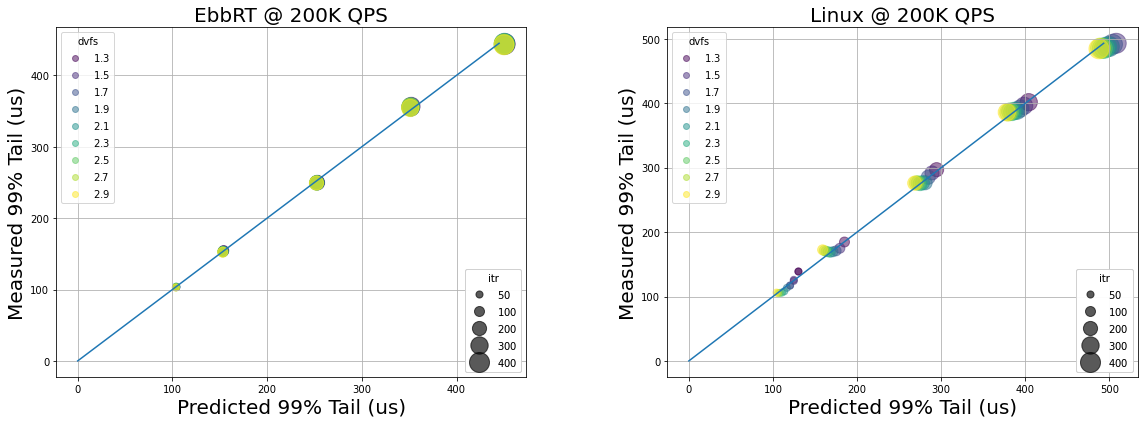

In [23]:
plt.rcParams['figure.figsize'] = 16, 6
df_comb = df_comb[df_comb['itr'] != 350]

run_time(df_comb, n_iter=4000, lr=1, rqps=200000, rtail='99', 
           mpred=['time'], msys=['ebbrt_tuned', 'linux_tuned'], 
         fzeta=[55, 88], falpha=[-0.99, -0.3], fphi=[0.98, 1.1])

In [107]:
def inference_energy(d, n_iter, lr, workload, sys, zeta, alpha, phi, fbeta, fgamma, fdelta, print_freq=1000):
    p_static = {
        'c1':1.5, 
        'c3':0.5,
        'c4':0.25,
        'c7':34, # 34 Watts
        'busy': 10
    }
    chosen_sleep = 'c7'

    p_q = p_static[chosen_sleep]/10**6 # joules/us idle
    # p_detect = p_static[chosen_sleep]

    #starts randomly
#     beta = torch.tensor(torch.Tensor(1,1).uniform_(-7.0, -4.0), requires_grad=True)
#     gamma = torch.tensor(torch.Tensor(1,1).uniform_(-0.22, -0.17), requires_grad=True)
#     phi = torch.tensor(torch.Tensor(1,1).uniform_(0.98, 1.0), requires_grad=True)
    #zeta = torch.tensor(torch.Tensor(1,1).uniform_(56.45, 86.71), requires_grad=True)
    
    delta = torch.tensor(torch.Tensor(1,1).uniform_(fdelta[0], fdelta[1]), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(fgamma[0], fgamma[1]), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(fbeta[0], fbeta[1]), requires_grad=True)
    mu = torch.tensor(torch.Tensor(1,1).uniform_(-2.0, 2.0), requires_grad=True)
    #phi = torch.tensor(torch.Tensor(1,1).uniform_(fbeta[0], fbeta[1]), requires_grad=True)

    #df[['joules','itr', 'dvfs', 'QPS', read_99th, 'num_interrupts']]
    qps = d[:,3]
    ninterrupts = d[:,5]
    #energy = (d[:,0]/ninterrupts).log() ## joules/num_interrupts
    energy = (d[:,0]/ninterrupts)
    #energy = (d[:,0]/(qps).log()
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,4]
     
    #interarrival_time = (1/qps)*10**6
    #fixed_phi = phi.item()
    criterion = nn.MSELoss()
    optimizer_energy = optim.Adam([gamma, delta, beta, mu], lr=lr)
            
    for i in range(n_iter):
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        
        ## sigmetrics'22 equations
        #pred_energy = gamma * ((fixed_phi*itr) * (dvfs**beta)) #+ (AA*(dvfs**beta))
        #pred_energy = (gamma*(fixed_phi*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))
        #pred_energy = gamma+(phi+np.log(itr))+(beta*np.log(dvfs))
        
        ## nsdi'23 equations
        #pred_energy = P_work*max_time/dvfs**(1+alpha) + P*itr_suppress*itr
        pred_energy = gamma*(dvfs**(1+beta)) * zeta/dvfs**(1+alpha) + (delta*phi*itr)*(dvfs**mu)
            
        #pred_energy = (*itr + t_busy_energy)*p_q
        loss_energy = criterion(pred_energy, energy)
        #round(math.sqrt(loss_time.item()), 5)
        if i % print_freq == 0:
            print(f'loss_energy={round(math.sqrt(loss_energy.item()), 5)} gamma={gamma.item()} beta={beta.item()} delta={delta.item()} mu={mu.item()}')
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    
    return pred_energy

In [108]:
def run_energy(df_comb, n_iter=2000, lr=1, rqps=400000, rtail='99', 
               msys=['ebbrt_tuned'], mpred=['energy', 'time'], zeta=0.0, alpha=0.0, phi=0.0,
              fbeta=[-7.0, -4.0], fgamma=[-0.22, -0.17], fdelta=[0.98, 1.0]):  
    
    df_comb = df_comb[df_comb['QPS'] == rqps]
    i=1
    
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        rt = 'read_'+rtail+'th'
        df = df[['joules','itr', 'dvfs', 'QPS', rt, 'num_interrupts']]
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        pred_energy = inference_energy(d, n_iter, lr, 'mcd', sys, zeta, alpha, phi, fbeta, fgamma, fdelta, print_freq=1000)
        df[f'pre_energy lr={lr}'] = pred_energy.view(tnum, 1).detach().numpy()
                
        for pred_name in mpred:
            pred = pred_energy
            qps = d[:,3]
            #yvalue = (d[:,0]/d[:,5]).log()
            yvalue = (d[:,0]/d[:,5])

            #fig, ax = plt.subplots()
            ax = plt.subplot(1, len(msys)*len(mpred), i)
            
            if sys == 'ebbrt_tuned':
                plt.title(f'EbbRT @ {int(rqps/1000)}K QPS', fontsize=20)
            else:
                plt.title(f'Linux @ {int(rqps/1000)}K QPS', fontsize=20)
                
            #plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time,2)} \n alpha={round(alpha,2)} beta={round(beta.item(),2)} \n p_detect={round(p_detect.item(),2)}')
            plt.ylabel('Measured Energy (J)', fontsize=20)
            plt.xlabel('Predicted Energy (J)', fontsize=20)
           

            tmax = yvalue.max().item()
            tmin = yvalue.min().item()
            #print(yvalue.min(), yvalue.max(), tmin, tmax)
            plt.plot(np.linspace(tmin, tmax, 10), np.linspace(tmin, tmax, 10))
                
            print('measurement', yvalue.mean(), yvalue.std())
            
            scatter = ax.scatter(pred.detach().numpy()[0], yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.5)
            
            
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)
            
            plt.grid(True)
            plt.tight_layout()
            i += 1
    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    

SYS ebbrt_tuned
loss_energy=2143.17726 gamma=2.3681387901306152 beta=-2.020653247833252 delta=3.927431583404541 mu=0.9007556438446045


<ipython-input-107-14535f276695>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta = torch.tensor(torch.Tensor(1,1).uniform_(fdelta[0], fdelta[1]), requires_grad=True)
<ipython-input-107-14535f276695>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(fgamma[0], fgamma[1]), requires_grad=True)
<ipython-input-107-14535f276695>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(fbeta[0], fbeta[1]), requires_grad=True)
<ipython-input-107-14535f

loss_energy=0.39192 gamma=0.8214063048362732 beta=-11.220684051513672 delta=-0.04115524888038635 mu=-6.268528461456299
loss_energy=0.27088 gamma=0.5716808438301086 beta=-11.247697830200195 delta=-0.028223305940628052 mu=-6.268528461456299
loss_energy=0.14127 gamma=0.2992950975894928 beta=-11.266242980957031 delta=-0.014684107154607773 mu=-6.268528461456299
loss_energy=0.04717 gamma=0.0997881218791008 beta=-11.272489547729492 delta=-0.004871781915426254 mu=-6.268528461456299
loss_energy=0.00757 gamma=0.015567498281598091 beta=-11.273193359375 delta=-0.0007408984820358455 mu=-6.268528461456299
loss_energy=0.00093 gamma=0.0003249791043344885 beta=-11.273193359375 delta=6.538396519317757e-06 mu=-6.268528461456299
loss_energy=0.00086 gamma=-0.00040861446177586913 beta=-11.273193359375 delta=4.2511121137067676e-05 mu=-6.268528461456299
loss_energy=0.00086 gamma=-0.0004127329448238015 beta=-11.273193359375 delta=4.271307261660695e-05 mu=-6.268528461456299
loss_energy=0.00086 gamma=-0.00041273

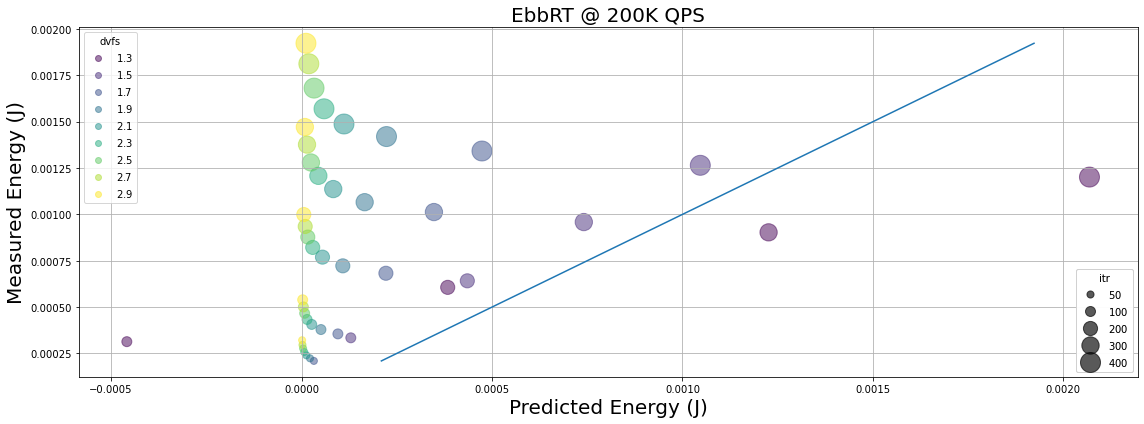

In [109]:
plt.rcParams['figure.figsize'] = 16, 6
df_comb = df_comb[df_comb['itr'] != 350]

#zeta=56.4552116394043 alpha=-0.44703954458236694 phi=1.0780853033065796
run_energy(df_comb, n_iter=20000, lr=1, rqps=200000, rtail='99', 
           mpred=['time'], msys=['ebbrt_tuned'], zeta=56.45, alpha=-0.44, phi=1.07,
          fbeta=[-4.0, 4.0], fgamma=[-4.0, 4.0], fdelta=[-4.0, 4.0])